<h1>A. Data Collection & Exploration

<h2>Import libraries

In [1]:
import numpy as np, matplotlib as mpl, matplotlib.pyplot as plt, pandas as pd
import seaborn as sns
%matplotlib inline
import sklearn
import xgboost as xgb
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from mpl_toolkits import mplot3d
from sklearn.preprocessing import LabelEncoder
from pylift import TransformedOutcome
from pylift.generate_data import dgp
from pylift.eval import UpliftEval
from sklearn.cluster import KMeans
from statistics import mean
import sklearn.metrics

<h2>Import dataset

In [2]:
df_data = pd.read_csv('WA_Fn-UseC_-HR-Employee-Attrition.csv')
df_data.index.name = "id"
df_model = df_data.copy()

<h2>Data exploratioin

In [3]:
pd.options.display.max_columns=100
df_model

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,2,Female,94,3,2,Sales Executive,4,Single,5993,19479,8,Y,Yes,11,3,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,3,Male,61,2,2,Research Scientist,2,Married,5130,24907,1,Y,No,23,4,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,4,Male,92,2,1,Laboratory Technician,3,Single,2090,2396,6,Y,Yes,15,3,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,4,Female,56,3,1,Research Scientist,3,Married,2909,23159,1,Y,Yes,11,3,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,1,Male,40,3,1,Laboratory Technician,2,Married,3468,16632,9,Y,No,12,3,4,80,1,6,3,3,2,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1465,36,No,Travel_Frequently,884,Research & Development,23,2,Medical,1,2061,3,Male,41,4,2,Laboratory Technician,4,Married,2571,12290,4,Y,No,17,3,3,80,1,17,3,3,5,2,0,3
1466,39,No,Travel_Rarely,613,Research & Development,6,1,Medical,1,2062,4,Male,42,2,3,Healthcare Representative,1,Married,9991,21457,4,Y,No,15,3,1,80,1,9,5,3,7,7,1,7
1467,27,No,Travel_Rarely,155,Research & Development,4,3,Life Sciences,1,2064,2,Male,87,4,2,Manufacturing Director,2,Married,6142,5174,1,Y,Yes,20,4,2,80,1,6,0,3,6,2,0,3


<h2>Define Cols

In [4]:
#choose the single dependent variable (Positive Outcome)
treat = 'OverTime'

In [5]:
#choose the treatment variable
target = "Attrition"

In [6]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   int64 
 7   EducationField            1470 non-null   object
 8   EmployeeCount             1470 non-null   int64 
 9   EmployeeNumber            1470 non-null   int64 
 10  EnvironmentSatisfaction   1470 non-null   int64 
 11  Gender                    1470 non-null   object
 12  HourlyRate                1470 non-null   int64 
 13  JobInvolvement            1470 non-null   int64 
 14  JobLevel                

<h2>Check N-uniques for non-categorical data

In [7]:
#Checking uniques data in Department column
object_cols = [col for col in df_data.columns if df_data[col].dtype != "object"]
numbers = [[obj,df_data[obj].nunique()] for obj in object_cols]
numbers_data = pd.DataFrame(numbers, columns = ['column', 'N-unique']) 

In [8]:
numbers_data.sort_values(by='N-unique',ascending=False)

,column,N-unique
5,EmployeeNumber,1470
12,MonthlyRate,1427
11,MonthlyIncome,1349
1,DailyRate,886
7,HourlyRate,71
0,Age,43
19,TotalWorkingYears,40
22,YearsAtCompany,37
2,DistanceFromHome,29
23,YearsInCurrentRole,19


<h2>Define Columns to Cluster</h2>
Define column to cluster with high amount of N-Uniques

In [9]:
#choose a column with hiearchy to be label encoded
cluster_cols=['MonthlyRate','MonthlyIncome','DailyRate','HourlyRate','Age']

<h2>Check uniques for categorical data

In [10]:
#Checking uniques data in Department column
object_cols = [col for col in df_data.columns if df_data[col].dtype == "object"]
for obj in object_cols:
    print('\n', obj)
    for unique in df_data[obj].unique():
        print("{} {}".format(unique,sum(df_data[obj] == unique)))


 Attrition
Yes 237
No 1233

 BusinessTravel
Travel_Rarely 1043
Travel_Frequently 277
Non-Travel 150

 Department
Sales 446
Research & Development 961
Human Resources 63

 EducationField
Life Sciences 606
Other 82
Medical 464
Marketing 159
Technical Degree 132
Human Resources 27

 Gender
Female 588
Male 882

 JobRole
Sales Executive 326
Research Scientist 292
Laboratory Technician 259
Manufacturing Director 145
Healthcare Representative 131
Manager 102
Sales Representative 83
Research Director 80
Human Resources 52

 MaritalStatus
Single 470
Married 673
Divorced 327

 Over18
Y 1470

 OverTime
Yes 416
No 1054


<h2>Replace Yes or No to 1 or 0

In [11]:
df_model.Attrition.replace(to_replace = dict(Yes = 0, No = 1), inplace = True)
df_model.OverTime.replace(to_replace = dict(Yes = 0, No = 1), inplace = True)

<h2>Rename Inverted Data

In [12]:
df_model = df_model.rename(columns={"Attrition": "Stay"})
df_model = df_model.rename(columns={"OverTime": "NotOvertime"})
treat = 'NotOvertime'
df_model.head()

,Age,Stay,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,NotOvertime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,41,0,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,2,Female,94,3,2,Sales Executive,4,Single,5993,19479,8,Y,0,11,3,1,80,0,8,0,1,6,4,0,5
1,49,1,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,3,Male,61,2,2,Research Scientist,2,Married,5130,24907,1,Y,1,23,4,4,80,1,10,3,3,10,7,1,7
2,37,0,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,4,Male,92,2,1,Laboratory Technician,3,Single,2090,2396,6,Y,0,15,3,2,80,0,7,3,3,0,0,0,0
3,33,1,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,4,Female,56,3,1,Research Scientist,3,Married,2909,23159,1,Y,0,11,3,3,80,0,8,3,3,8,7,3,0
4,27,1,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,1,Male,40,3,1,Laboratory Technician,2,Married,3468,16632,9,Y,1,12,3,4,80,1,6,3,3,2,2,2,2


<h2>Define columns to Label encode

In [13]:
#choose a column with wide range to be clusterred
label_cols = ['BusinessTravel']

<h1>B. Data Preprocessing

<h2>Label encoding hierarchy columns

In [14]:
#Label encoding
print("label encoding columns:",label_cols)
label_encoder = LabelEncoder()
for col in label_cols:
    df_model[col] = label_encoder.fit_transform(df_data[col])
    df_model[col] = label_encoder.transform(df_data[col])
print(">>label encoding finished")
df_model[label_cols].head()

label encoding columns: ['BusinessTravel']
>>label encoding finished


,BusinessTravel
id,
0,2
1,1
2,2
3,1
4,2


<h2>Data cleaning

In [15]:
df_model

,Age,Stay,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,NotOvertime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,41,0,2,1102,Sales,1,2,Life Sciences,1,1,2,Female,94,3,2,Sales Executive,4,Single,5993,19479,8,Y,0,11,3,1,80,0,8,0,1,6,4,0,5
1,49,1,1,279,Research & Development,8,1,Life Sciences,1,2,3,Male,61,2,2,Research Scientist,2,Married,5130,24907,1,Y,1,23,4,4,80,1,10,3,3,10,7,1,7
2,37,0,2,1373,Research & Development,2,2,Other,1,4,4,Male,92,2,1,Laboratory Technician,3,Single,2090,2396,6,Y,0,15,3,2,80,0,7,3,3,0,0,0,0
3,33,1,1,1392,Research & Development,3,4,Life Sciences,1,5,4,Female,56,3,1,Research Scientist,3,Married,2909,23159,1,Y,0,11,3,3,80,0,8,3,3,8,7,3,0
4,27,1,2,591,Research & Development,2,1,Medical,1,7,1,Male,40,3,1,Laboratory Technician,2,Married,3468,16632,9,Y,1,12,3,4,80,1,6,3,3,2,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1465,36,1,1,884,Research & Development,23,2,Medical,1,2061,3,Male,41,4,2,Laboratory Technician,4,Married,2571,12290,4,Y,1,17,3,3,80,1,17,3,3,5,2,0,3
1466,39,1,2,613,Research & Development,6,1,Medical,1,2062,4,Male,42,2,3,Healthcare Representative,1,Married,9991,21457,4,Y,1,15,3,1,80,1,9,5,3,7,7,1,7
1467,27,1,2,155,Research & Development,4,3,Life Sciences,1,2064,2,Male,87,4,2,Manufacturing Director,2,Married,6142,5174,1,Y,0,20,4,2,80,1,6,0,3,6,2,0,3


In [16]:
#remove unused columns
###
#DROP unused rows
df_model = df_model.drop(['Over18','StandardHours','StockOptionLevel','EmployeeCount','EmployeeNumber'],axis=1)

<h2>Cluster & One Hot Encoding

In [17]:
#function to order clusters
def order_cluster(cluster_field_name, target_field_name,df,ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final

In [18]:
[col for col in df_model.columns if df_model[col].dtype == "float64"]

[]

In [19]:
# #preparing float columns to cluster
# print('Clustering columns:',cluster_cols)
# #creating the clusters
# for col in cluster_cols:
#     col_cluster = col + "_cluster"
#     kmeans = KMeans(n_clusters=5)
#     kmeans.fit(df_model[[col]])
#     df_model[col_cluster] = kmeans.predict(df_model[[col]])
#     #order the clusters
#     df_model = order_cluster(col_cluster, col, df_model, True)
# print('>>Cluster succeeded!')
#dropping columns that have been clustered
df_model = df_model.drop(cluster_cols,axis=1)

#one hot encoding the rest columns
dummies = pd.get_dummies(df_model)
print("\nOne Hot Encoding:",dummies.columns.values)
df_model = dummies
print('>>One Hot Encoding succeeded!')


One Hot Encoding: ['Stay' 'BusinessTravel' 'DistanceFromHome' 'Education'
 'EnvironmentSatisfaction' 'JobInvolvement' 'JobLevel' 'JobSatisfaction'
 'NumCompaniesWorked' 'NotOvertime' 'PercentSalaryHike'
 'PerformanceRating' 'RelationshipSatisfaction' 'TotalWorkingYears'
 'TrainingTimesLastYear' 'WorkLifeBalance' 'YearsAtCompany'
 'YearsInCurrentRole' 'YearsSinceLastPromotion' 'YearsWithCurrManager'
 'Department_Human Resources' 'Department_Research & Development'
 'Department_Sales' 'EducationField_Human Resources'
 'EducationField_Life Sciences' 'EducationField_Marketing'
 'EducationField_Medical' 'EducationField_Other'
 'EducationField_Technical Degree' 'Gender_Female' 'Gender_Male'
 'JobRole_Healthcare Representative' 'JobRole_Human Resources'
 'JobRole_Laboratory Technician' 'JobRole_Manager'
 'JobRole_Manufacturing Director' 'JobRole_Research Director'
 'JobRole_Research Scientist' 'JobRole_Sales Executive'
 'JobRole_Sales Representative' 'MaritalStatus_Divorced'
 'MaritalStatus_

In [20]:
df_model

,Stay,BusinessTravel,DistanceFromHome,Education,EnvironmentSatisfaction,JobInvolvement,JobLevel,JobSatisfaction,NumCompaniesWorked,NotOvertime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Department_Human Resources,Department_Research & Development,Department_Sales,EducationField_Human Resources,EducationField_Life Sciences,EducationField_Marketing,EducationField_Medical,EducationField_Other,EducationField_Technical Degree,Gender_Female,Gender_Male,JobRole_Healthcare Representative,JobRole_Human Resources,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0,2,1,2,2,3,2,4,8,0,11,3,1,8,0,1,6,4,0,5,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1
1,1,1,8,1,3,2,2,2,1,1,23,4,4,10,3,3,10,7,1,7,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0
2,0,2,2,2,4,2,1,3,6,0,15,3,2,7,3,3,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1
3,1,1,3,4,4,3,1,3,1,0,11,3,3,8,3,3,8,7,3,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0
4,1,2,2,1,1,3,1,2,9,1,12,3,4,6,3,3,2,2,2,2,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1465,1,1,23,2,3,4,2,4,4,1,17,3,3,17,3,3,5,2,0,3,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0
1466,1,2,6,1,4,2,3,1,4,1,15,3,1,9,5,3,7,7,1,7,0,1,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0
1467,1,2,4,3,2,4,2,2,1,0,20,4,2,6,0,3,6,2,0,3,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0


<h2>Categorizing target class

Categorizing employees into: CN(0), CR(1), TN(2), and TR(3)
>>Categorizing successfull!


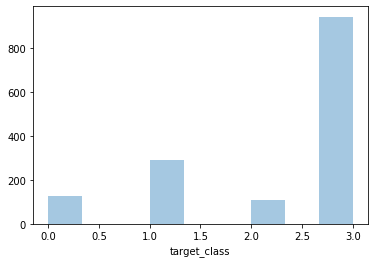

In [21]:
print("Categorizing employees into: CN(0), CR(1), TN(2), and TR(3)")
#to get the CN employees we can simply set the basic value of all data in column target_class equal to 0 
df_model['target_class'] = 0 #CN

#after that we set CR employees with target_class equal to 1 
df_model.loc[(df_model[treat] == 0) & (df_model.Stay > 0),'target_class'] = 1 #CR

#after that we set TN employees with with target_class equal to 2
df_model.loc[(df_model[treat] == 1) & (df_model.Stay == 0),'target_class'] = 2 #TN

#after that we set TR employees with with target_class equal to 3
df_model.loc[(df_model[treat] == 1) & (df_model.Stay > 0),'target_class'] = 3 #TR

print(">>Categorizing successfull!")
sns.distplot(a=df_model.target_class, kde=False)

<h2>Explore data Correlation

In [22]:
#measure the correlation of Employee who stay
pd.options.display.max_rows=100
correlation = df_model.corr(method ='pearson') 
correlation.Stay.sort_values() * 100

MaritalStatus_Single                 -17.541855
JobRole_Sales Representative         -15.723427
JobRole_Laboratory Technician         -9.829049
Department_Sales                      -8.085520
DistanceFromHome                      -7.792358
EducationField_Technical Degree       -6.935459
EducationField_Marketing              -5.578067
NumCompaniesWorked                    -4.349374
EducationField_Human Resources        -3.646620
JobRole_Human Resources               -3.621508
Gender_Male                           -2.945325
JobRole_Sales Executive               -1.977437
Department_Human Resources            -1.683201
PerformanceRating                     -0.288875
BusinessTravel                        -0.007378
JobRole_Research Scientist             0.035957
PercentSalaryHike                      1.347820
EducationField_Other                   1.789752
Gender_Female                          2.945325
Education                              3.137282
EducationField_Life Sciences           3

<h2>Create new dataframe for churn and uplift

In [23]:
#duplicate result to df_data for calculating MP & MPU
df_data_churn = df_model[['target_class','Stay',treat]]
print(df_data_churn.head())
# df_data_lift = df_model.copy()
df_data_uplift = df_model[['target_class','Stay',treat]]
print(df_data_uplift.head())

    target_class  Stay  NotOvertime
id                                 
0              0     0            0
1              3     1            1
2              0     0            0
3              1     1            0
4              3     1            1
    target_class  Stay  NotOvertime
id                                 
0              0     0            0
1              3     1            1
2              0     0            0
3              1     1            0
4              3     1            1


<h2>Predicting Target Class(Churn Uplift)

In [24]:
#create feature set and labels
X = df_model.drop(['target_class',treat,'Stay'],axis=1)
y = df_model.target_class
#splitting train and test groups
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
#fitting the model and predicting the probabilities using eXtreme Gradient Boosting
xgb_model = xgb.XGBClassifier().fit(X_train, y_train)
#Calculate probabilities for all customers using eXtreme Gradient Boost
overall_predict = xgb_model.predict(df_model.drop(['target_class',treat,'Stay'],axis=1))
overall_proba=xgb_model.predict_proba(df_model.drop(['target_class',treat,'Stay'],axis=1))
# insert predicted target to uplift dataframe
df_data_uplift['p_target'] = overall_predict
df_model['p_target'] = overall_predict
# assign probabilities to 4 different columns
df_data_uplift['proba_CN'] = overall_proba[:,0] 
df_data_uplift['proba_CR'] = overall_proba[:,1] 
df_data_uplift['proba_TN'] = overall_proba[:,2] 
df_data_uplift['proba_TR'] = overall_proba[:,3]
#calculate uplift score for all customers
df_data_uplift['uplift_score'] = df_data_uplift.eval('proba_CN/(proba_CN+proba_CR) + proba_TR/(proba_TN+proba_TR) - proba_TN/(proba_TN+proba_TR) - proba_CR/(proba_CN+proba_CR)')
#assign it back to main dataframe
df_data_uplift['uplift_score'] = df_data_uplift['uplift_score']

C:\Users\Davin\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
C:\Users\Davin\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
C:\Users\Davin\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a

In [25]:
df_data_uplift

,target_class,Stay,NotOvertime,p_target,proba_CN,proba_CR,proba_TN,proba_TR,uplift_score
id,,,,,,,,,
0,0,0,0,0,0.426541,0.097169,0.109605,0.366684,1.168674
1,3,1,1,3,0.027886,0.228505,0.022360,0.721249,0.157390
2,0,0,0,0,0.434759,0.078700,0.133854,0.352687,1.143223
3,1,1,0,3,0.099383,0.342011,0.021553,0.537052,0.373146
4,3,1,1,3,0.232114,0.052546,0.054051,0.661289,1.479695
...,...,...,...,...,...,...,...,...,...
1465,3,1,1,3,0.020249,0.343844,0.037958,0.597948,-0.008152
1466,3,1,1,3,0.025642,0.163215,0.012210,0.798932,0.241445
1467,1,1,0,3,0.044810,0.319491,0.019177,0.616522,0.185673


<h2>Predicting Target (Churn Prediction)

In [26]:
df_model

,Stay,BusinessTravel,DistanceFromHome,Education,EnvironmentSatisfaction,JobInvolvement,JobLevel,JobSatisfaction,NumCompaniesWorked,NotOvertime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Department_Human Resources,Department_Research & Development,Department_Sales,EducationField_Human Resources,EducationField_Life Sciences,EducationField_Marketing,EducationField_Medical,EducationField_Other,EducationField_Technical Degree,Gender_Female,Gender_Male,JobRole_Healthcare Representative,JobRole_Human Resources,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,target_class,p_target
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0,2,1,2,2,3,2,4,8,0,11,3,1,8,0,1,6,4,0,5,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0
1,1,1,8,1,3,2,2,2,1,1,23,4,4,10,3,3,10,7,1,7,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,3,3
2,0,2,2,2,4,2,1,3,6,0,15,3,2,7,3,3,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0
3,1,1,3,4,4,3,1,3,1,0,11,3,3,8,3,3,8,7,3,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,1,3
4,1,2,2,1,1,3,1,2,9,1,12,3,4,6,3,3,2,2,2,2,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,3,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1465,1,1,23,2,3,4,2,4,4,1,17,3,3,17,3,3,5,2,0,3,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,3,3
1466,1,2,6,1,4,2,3,1,4,1,15,3,1,9,5,3,7,7,1,7,0,1,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,3,3
1467,1,2,4,3,2,4,2,2,1,0,20,4,2,6,0,3,6,2,0,3,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,3


In [27]:
#create feature set and labels
z = df_model.Stay
#splitting train and test groups
X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.3, random_state=42)
#fitting the model and predicting the probabilities using eXtreme Gradient Boosting
xgb_model2 = xgb.XGBClassifier().fit(X_train, z_train)
#Calculate probabilities for all customers using eXtreme Gradient Boost
overall_predict2 = xgb_model2.predict(df_model.drop(['target_class',treat,'Stay','p_target'],axis=1))
overall_proba2 = xgb_model2.predict_proba(df_model.drop(['target_class',treat,'Stay','p_target'],axis=1))
# df_data_lift = df_model.copy()
df_data_churn['p_stay'] = overall_predict2
df_model['p_stay'] = overall_predict2
df_data_churn['stay_score'] = overall_proba[:,0] 
df_data_churn['churn_score'] = overall_proba[:,1] 

C:\Users\Davin\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Davin\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
C:\Users\Davin\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a s

<h2>Rank data from Churn prediction

In [28]:
#choose treatment only
df_data_churn = df_data_churn[df_data_uplift.target_class > 1]
print("Ranking data for Churn Prediction")
df_data_churn = df_data_churn.sort_values(by ='stay_score',ascending=False)
df_data_churn

Ranking data for Churn Prediction


,target_class,Stay,NotOvertime,p_stay,stay_score,churn_score
id,,,,,,
23,3,1,1,1,0.502916,0.158452
1222,2,0,1,0,0.491423,0.134394
109,3,1,1,0,0.490216,0.060018
301,3,1,1,0,0.486467,0.062464
752,2,0,1,1,0.474325,0.121719
...,...,...,...,...,...,...
1421,3,1,1,1,0.003230,0.104403
1184,3,1,1,1,0.003168,0.067067
1288,3,1,1,1,0.002658,0.140053


In [29]:
df_data_churn = df_data_churn.reset_index()

<h2>Rank data from Uplift prediction

In [30]:
#choose treatment only

df_data_uplift = df_data_uplift[df_data_uplift.target_class > 1]
print("Ranking data for Churn Uplift")
df_data_uplift = df_data_uplift.sort_values(by ='uplift_score',ascending=True)
df_data_uplift

Ranking data for Churn Uplift


,target_class,Stay,NotOvertime,p_target,proba_CN,proba_CR,proba_TN,proba_TR,uplift_score
id,,,,,,,,,
749,2,0,1,2,0.053757,0.228379,0.547550,0.170313,-1.144425
1111,2,0,1,1,0.005416,0.487811,0.285721,0.221052,-1.105648
780,2,0,1,2,0.038777,0.109687,0.592650,0.258887,-0.869583
1162,2,0,1,3,0.017557,0.139344,0.411762,0.431337,-0.752985
33,2,0,1,3,0.009427,0.247221,0.299940,0.443411,-0.733528
...,...,...,...,...,...,...,...,...,...
793,3,1,1,3,0.118515,0.026518,0.030108,0.824858,1.563881
1193,3,1,1,3,0.234464,0.047697,0.029584,0.688256,1.579496
123,3,1,1,3,0.086124,0.020941,0.011486,0.881449,1.583088


In [31]:
df_data_uplift = df_data_uplift.reset_index()

In [32]:
#define basic variable c=cost, j=decile_count
c=0
j=round(len(df_data_churn)/10)

#prepare 3 dataframe for CPMP
CPMP1 = pd.DataFrame({"n":[], 
                      "retained":[], 
                      "non_retained":[], 
                      "false":[], 
                      "r_profit":[], 
                      "n_profit":[], 
                      "false_profit":[], 
                      "mp":[]})
CPMP2, CPMP3, CUMP1, CUMP2, CUMP3=CPMP1.copy(), CPMP1.copy(), CPMP1.copy(), CPMP1.copy(), CPMP1.copy()

#1
b1=200
i1=10
p1_1=(b1-i1-c)
p2_1=(-c)
p3_1=(-i1-c)
p4_1=(b1-c)

#2
b2=100
i2=10
p1_2=(b2-i2-c)
p2_2=(-c)
p3_2=(-i2-c)
p4_2=(b2-c)

#3
b3=100
i3=50
p1_3=(b3-i3-c)
p2_3=(-c)
p3_3=(-i3-c)
p4_3=(b3-c)

CP_list1, CP_list2, CP_list3, CU_list1, CU_list2, CU_list3=[], [], [], [], [], []

for i in range(10):
    n=i*j
    m=(i+1)*j
    
         
    #Churn Prediction Variables
    ###true predicted churn and r
    r = sum(df_data_churn.target_class[n:m]==3)
    ###true predicted churn and rejected
    nr = sum(df_data_churn.target_class[n:m]==0) + sum(df_data_churn.target_class[n:m]==2)
    ###fr predicted churn
    fr = sum(df_data_churn.target_class[n:m]==1)
    
#     #predicted target class
#     CN=sum(df_data_uplift.p_target[n:m]==0)
#     CR=sum(df_data_uplift.p_target[n:m]==1)
#     TN=sum(df_data_uplift.p_target[n:m]==2)
#     TR=sum(df_data_uplift.p_target[n:m]==3)
    
    #Churn Uplift Variables
    u_r=sum(df_data_uplift.target_class[n:m]==3)
    u_nr=sum(df_data_uplift.target_class[n:m]==0) + sum(df_data_uplift.target_class[n:m]==2)
    u_fr=sum(df_data_uplift.target_class[n:m]==1)
    
    #Churn Prediction mp 
    ###r as r, nr as nr, fr r as fr
    r_profit1=(r*p1_1)
    nr_profit1=(nr*p2_1)
    fr_profit1=(fr*p3_1)
    
    r_profit2=(r*p1_2)
    nr_profit2=(nr*p2_2)
    fr_profit2=(fr*p3_2)
    
    r_profit3=(r*p1_3)
    nr_profit3=(nr*p2_3)
    fr_profit3=(fr*p3_3)
    
    mp1=(r_profit1 + nr_profit1 + fr_profit1)/j
    mp2=(r_profit2 + nr_profit2 + fr_profit2)/j
    mp3=(r_profit3 + nr_profit3 + fr_profit3)/j
    
    u_r_profit1=(u_r*p1_1)
    u_nr_profit1=(u_nr*p2_1)
    u_fr_profit1=(u_fr*p3_1)
    
    u_r_profit2=(u_r*p1_2)
    u_nr_profit2=(u_nr*p2_2)
    u_fr_profit2=(u_fr*p3_2)
    
    u_r_profit3=(u_r*p1_3)
    u_nr_profit3=(u_nr*p2_3)
    u_fr_profit3=(u_fr*p3_3)
    
    #Churn Uplift mp
    u_mp1=(u_r_profit1 + u_nr_profit1 + u_fr_profit1)/j
    u_mp2=(u_r_profit2 + u_nr_profit2 + u_fr_profit2)/j
    u_mp3=(u_r_profit3 + u_nr_profit3 + u_fr_profit3)/j

    CP_list1.append(pd.Series([((i+1)/10), r, nr, fr,r_profit1, nr_profit1, fr_profit1, mp1], index=CPMP1.columns))
    CP_list2.append(pd.Series([((i+1)/10), r, nr, fr,r_profit2, nr_profit2, fr_profit2, mp2], index=CPMP2.columns))    
    CP_list3.append(pd.Series([((i+1)/10), r, nr, fr,r_profit3, nr_profit3, fr_profit3, mp3], index=CPMP3.columns))    
        
    CU_list1.append(pd.Series([((i+1)/10), u_r, u_nr, u_fr,r_profit1, u_nr_profit1, u_fr_profit1, u_mp1], index=CUMP1.columns))
    CU_list2.append(pd.Series([((i+1)/10), u_r, u_nr, u_fr,r_profit2, u_nr_profit2, u_fr_profit2, u_mp2], index=CUMP2.columns))    
    CU_list3.append(pd.Series([((i+1)/10), u_r, u_nr, u_fr,r_profit3, u_nr_profit3, u_fr_profit3, u_mp3], index=CUMP3.columns)) 
    
#     profit1.append(mp1)
#     profit2.append(mp2)
#     profit3.append(mp3)
#     profit4.append(mp4)
#     profit5.append(mp5)
#     profit6.append(mp6)
    
#     #Churn Prediction Variables
#     CP_lift = sum(df_data_churn[j:]['Stay'] ==1)
#     CP_non_lift = sum(df_data_churn[j:]['Stay'] ==0)
#     CU_lift = sum(df_data_uplift[j:]['Stay'] ==1)
#     CU_non_lift = sum(df_data_uplift[j:]['Stay'] ==0)
    
#     #Churn Prediction mpu
#     mpu1=((CP_lift*p4_1)-(CP_non_lift*i1))/j
#     mpu2=((CP_lift*p4_2)-(CP_non_lift*i2))/j
#     mpu3=((CP_lift*p4_3)-(CP_non_lift*i3))/j
    
#     #Churn Uplift mpu
#     mpu4=((CU_lift*p4_1)-(CU_non_lift*i1))/j
#     mpu5=((CU_lift*p4_2)-(CU_non_lift*i2))/j
#     mpu6=((CU_lift*p4_3)-(CU_non_lift*i3))/j
        
#     uplift1.append(mpu1)
#     uplift2.append(mpu2)
#     uplift3.append(mpu3)
#     uplift4.append(mpu4)
#     uplift5.append(mpu5)
#     uplift6.append(mpu6)
    
#     #employee churn rate
#     churn_rate1=(TN)/j    
#     churn_rate2=(TN+CN)/j    
#     churn1.append(churn_rate1)
#     churn2.append(churn_rate2)
    
#     #employee cumulative uplift
#     cum_u_rate1=(CR)/j    
#     cum_u_rate2=(CR+TR)/j    
#     cum1.append(churn_rate1)
#     cum2.append(churn_rate2)
    
#     print("\ncalculating total employees for Q{}({}-{})".format(i+1,n,m))
#     print("CN=",CN)
#     print("CR=",CR)
#     print("TN=",TN)
#     print("TR=",TR)
    
#     print("\nr=",r)
#     print("u_nr=",u_nr)
#     print("fr=",fr)
    
#     print("\nu_r=",u_r)
#     print("u_nr=",u_nr)
#     print("u_fr=",u_fr)
    
#     print("\nCP | MP2=(({}*{})+({}*{})+({}*{}) )/{}={}".format(r,p1_2,nr,p2_2,fr,p3_2,j,mp2))
#     print("CU | MP2=(({}*{})+({}*{})+({}*{}) )/{}={}".format(u_r,p1_2,u_nr,p2_2,u_fr,p3_2,j,mp5))
#     print("CP | MPU2=(({}*{})-({}*{}) )/{}={}".format(CP_lift,p4_2,CP_non_lift,p4_2,j,mpu2))
#     print("CU | MPU2=(({}*{})-({}*{}) )/{}={}".format(CU_lift,p4_2,CU_non_lift,p4_2,j,mpu5))

CPMP1 = CPMP1.append(CP_list1 , ignore_index=True)
CPMP2 = CPMP2.append(CP_list2 , ignore_index=True)
CPMP3 = CPMP3.append(CP_list3 , ignore_index=True)

CUMP1 = CUMP1.append(CU_list1 , ignore_index=True)
CUMP2 = CUMP2.append(CU_list2 , ignore_index=True)
CUMP3 = CUMP3.append(CU_list3 , ignore_index=True)

In [33]:
CPMP1['method'] = 'churn_prediction'
CPMP2['method'] = 'churn_prediction'
CPMP3['method'] = 'churn_prediction'

CUMP1['method'] = 'uplift_modelling'
CUMP2['method'] = 'uplift_modelling'
CUMP3['method'] = 'uplift_modelling'

In [64]:
result_mp1 = pd.concat([CPMP1, CUMP1])
result_mp1 = result_mp1.sort_values(by='n')

result_mp2 = pd.concat([CPMP2, CUMP2])
result_mp2 = result_mp2.sort_values(by='n')

result_mp3 = pd.concat([CPMP3, CUMP3])
result_mp3 = result_mp3.sort_values(by='n')

Text(37.75097222222223, 0.5, 'Maximum Profit')

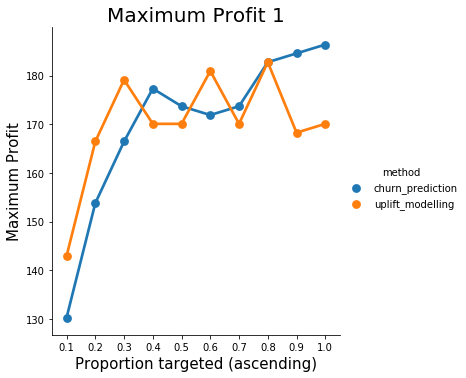

In [87]:
sns.catplot(x='n', y='mp', hue='method', data=result_mp1, kind="point")
plt.title('Maximum Profit 1',fontsize=20)
plt.xlabel('Proportion targeted (ascending)',fontsize=15)
plt.ylabel('Maximum Profit',fontsize=15)

Text(35.66546875, 0.5, 'Maximum Profit')

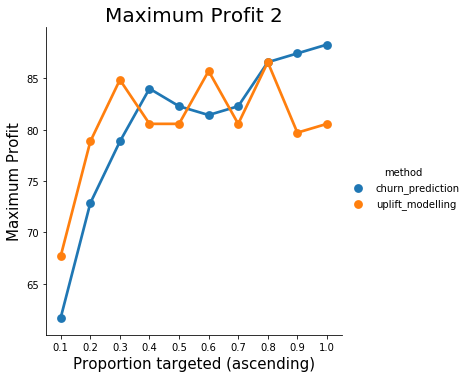

In [88]:
sns.catplot(x='n', y='mp', hue='method', data=result_mp2, kind="point")
plt.title('Maximum Profit 2',fontsize=20)
plt.xlabel('Proportion targeted (ascending)',fontsize=15)
plt.ylabel('Maximum Profit',fontsize=15)

Text(35.623758680555554, 0.5, 'Maximum Profit')

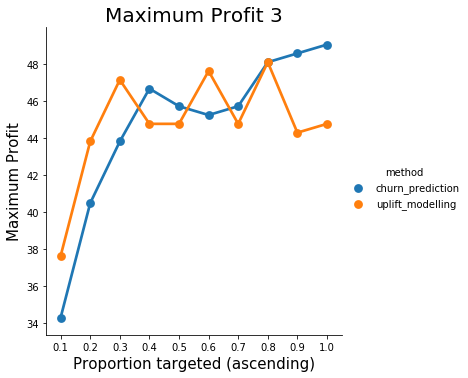

In [89]:
sns.catplot(x='n', y='mp', hue='method', data=result_mp3, kind="point")
plt.title('Maximum Profit 3',fontsize=20)
plt.xlabel('Proportion targeted (ascending)',fontsize=15)
plt.ylabel('Maximum Profit',fontsize=15)

<h2>Pylift

In [ ]:
df_data_pylift = df_model.copy()
df_data_pylift.drop(['target_class'], axis=1)
df_data_pylift

pylift modelling

In [ ]:
up = TransformedOutcome(df_model, col_treatment=treat, col_outcome='Stay')

In [ ]:
up.randomized_search(n_iter=20, n_jobs=10, random_state=46)

In [ ]:
up.fit(**up.rand_search_.best_params_)

In [ ]:
up.plot(plot_type='cuplift')

In [ ]:
up.test_results_.q1_cgains

In [ ]:
up.plot(plot_type='qini')

In [ ]:
up.shuffle_fit(params=up.rand_search_.best_params_, nthread=30, iterations=5);
up.plot(show_shuffle_fits=True)

In [ ]:
up.plot(show_theoretical_max=True, show_practical_max=True, show_no_dogs=True)

<h1>Causal Lift

In [ ]:
def calc_cumulative_gains(df: pd.DataFrame, actual_col: str, predicted_col:str, probability_col:str):
    df.sort_values(by=probability_col, ascending=False, inplace=True)

    subset = df[df[predicted_col] == True]

    rows = []
    for group in np.array_split(subset, 10):
        score = sklearn.metrics.accuracy_score(group[actual_col].tolist(),
                                                   group[predicted_col].tolist(),
                                                   normalize=False)

        rows.append({'NumCases': len(group), 'NumCorrectPredictions': score})

    lift = pd.DataFrame(rows)

    #Cumulative Gains Calculation
    lift['RunningCorrect'] = lift['NumCorrectPredictions'].cumsum()
    lift['PercentCorrect'] = lift.apply(
        lambda x: (100 / lift['NumCorrectPredictions'].sum()) * x['RunningCorrect'], axis=1)
    lift['CumulativeCorrectBestCase'] = lift['NumCases'].cumsum()
    lift['PercentCorrectBestCase'] = lift['CumulativeCorrectBestCase'].apply(
        lambda x: 100 if (100 / lift['NumCorrectPredictions'].sum()) * x > 100 else (100 / lift[
            'NumCorrectPredictions'].sum()) * x)
    lift['AvgCase'] = lift['NumCorrectPredictions'].sum() / len(lift)
    lift['CumulativeAvgCase'] = lift['AvgCase'].cumsum()
    lift['PercentAvgCase'] = lift['CumulativeAvgCase'].apply(
        lambda x: (100 / lift['NumCorrectPredictions'].sum()) * x)

    #Lift Chart
    lift['NormalisedPercentAvg'] = 1
    lift['NormalisedPercentWithModel'] = lift['PercentCorrect'] / lift['PercentAvgCase']

    return lift

In [ ]:
cum_lift = calc_cumulative_gains(df_data_churn, 'Stay', 'p_stay', 'stay_score')
cum_lift

In [ ]:
sns.lineplot(x='PercentAvgCase',y='PercentCorrectBestCase',data=cum_lift, label="Best Case (for current model)")
sns.lineplot(x='PercentAvgCase',y='PercentAvgCase',data=cum_lift, label="Average Case (for current model)")

In [ ]:
sns.lineplot(x='PercentAvgCase',y='NormalisedPercentWithModel',data=cum_lift, label="Normalised Respond Rate With Model")
sns.lineplot(x='PercentAvgCase',y='NormalisedPercentAvg',data=cum_lift, label="Normalised Respond Rate Avg")

In [ ]:
cum_uplift = calc_cumulative_gains(df_data_uplift, 'target_class', 'p_target', 'uplift_score')
cum_uplift

In [ ]:
sns.lineplot(x='PercentAvgCase',y='PercentCorrectBestCase',data=cum_uplift, label="Best Case (for current model)")
sns.lineplot(x='PercentAvgCase',y='PercentAvgCase',data=cum_uplift, label="Average Case (for current model)")

In [ ]:
sns.lineplot(x='PercentAvgCase',y='NormalisedPercentWithModel',data=cum_uplift, label="Normalised Respond Rate With Model")
sns.lineplot(x='PercentAvgCase',y='NormalisedPercentAvg',data=cum_uplift, label="Normalised Respond Rate Avg")

In [ ]:
#create feature set and labels
df_model_causal = df_model.drop(['target_class','p_stay','p_target'],axis=1)
df_model_causal.rename(columns={treat:'Treatment','Stay':'Outcome'}, inplace=True)
df_model_causal

In [ ]:
#splitting train and test groups
train_df, test_df = train_test_split(df_model_causal, test_size=0.2, random_state=42, stratify=df_model_causal['Treatment'])

In [ ]:
""" Step 0. Import CausalLift
"""

from causallift import CausalLift

""" Step 1. Feed datasets and optionally compute estimated propensity scores
using logistic regression if set enable_ipw = True.
"""


cl = CausalLift(train_df, test_df, enable_ipw=True, verbose=3)

""" Step 2. Train 2 classification models (XGBoost) for treated and untreated
samples independently and compute estimated CATE (Conditional Average Treatment
Effect), ITE (Individual Treatment Effect), or uplift score.
"""

train_df, test_df = cl.estimate_cate_by_2_models()

""" Step 3. Estimate how much conversion rate will increase by selecting treatment
(campaign) targets as recommended by the uplift modeling.
"""

estimated_effect_df = cl.estimate_recommendation_impact()

In [ ]:
estimated_effect_df